In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# RNG・チェーン設定
# -----------------------------
rng_key = random.PRNGKey(11)
num_chains = 3
rng_keys = random.split(rng_key, num_chains)

# -----------------------------
# データ生成（混合分布：2, -2）
# -----------------------------
n_samples = 1000
x1 = dist.Normal(2, 1).sample(rng_key, (n_samples // 2,))
x2 = dist.Normal(-2, 1).sample(rng_key, (n_samples // 2,))
x_data = jnp.concatenate([x1, x2])

# -----------------------------
# モデル定義
# -----------------------------
def model(x):
    mu0 = numpyro.sample("mu0", dist.Normal(-1, 1))
    mu1 = numpyro.sample("mu1", dist.Normal(1, 1))
    mixing_probs = jnp.array([0.5, 0.5])
    components = [dist.Normal(mu0, 1.0), dist.Normal(mu1, 1.0)]
    mixture = dist.MixtureGeneral(dist.Categorical(probs=mixing_probs), components)
    with numpyro.plate("data", len(x)):
        numpyro.sample("obs", mixture, obs=x)

# -----------------------------
# MCMC 実行
# -----------------------------
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)
mcmc.run(rng_keys, x=x_data)
mcmc.print_summary()

# -----------------------------
# サンプル取得
# -----------------------------
posterior_samples = mcmc.get_samples(group_by_chain=True)

/var/folders/j2/47mcq61x0n9cn6gkxl48ypbr0000gn/T/ipykernel_74259/1739015802.py:32: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)
sample: 100%|██████████| 4000/4000 [00:00<00:00, 4440.96it/s, 3 steps of size 9.51e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu0      0.60      1.89      1.90     -2.12      2.01      1.50     42.31
       mu1     -0.73      1.89     -2.04     -2.14      1.98      1.50     42.15

Number of divergences: 0


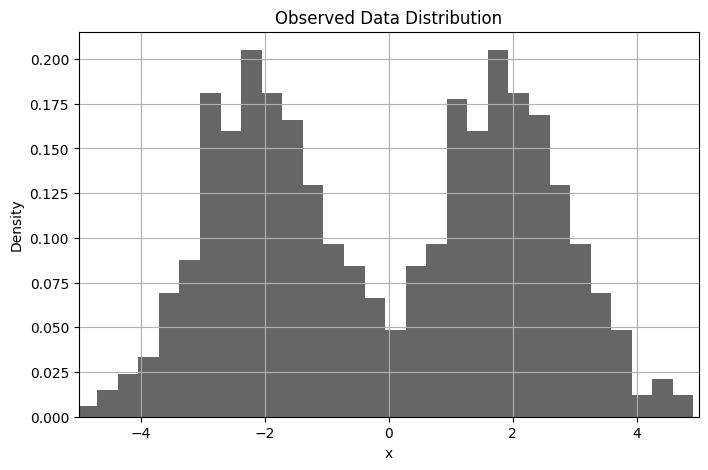

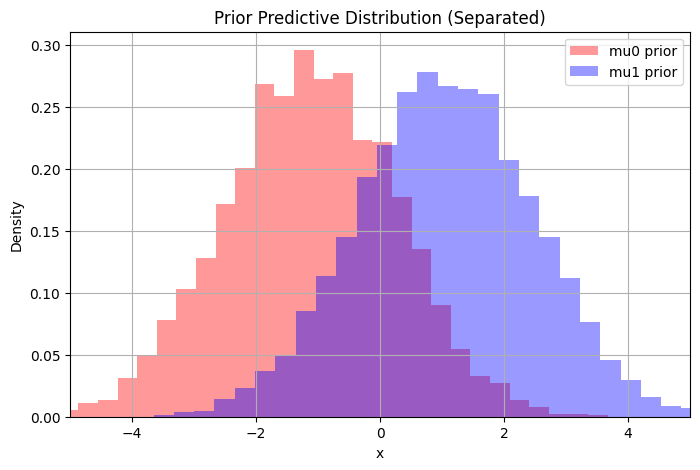

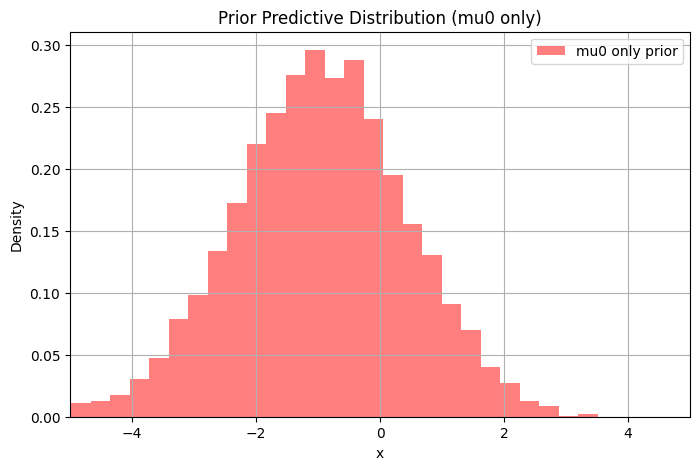

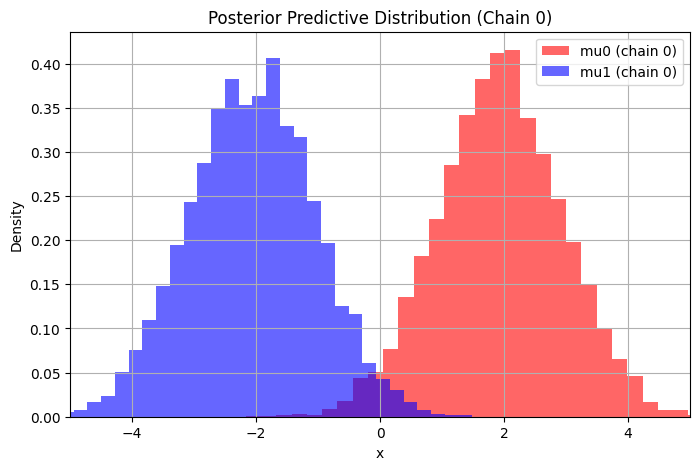

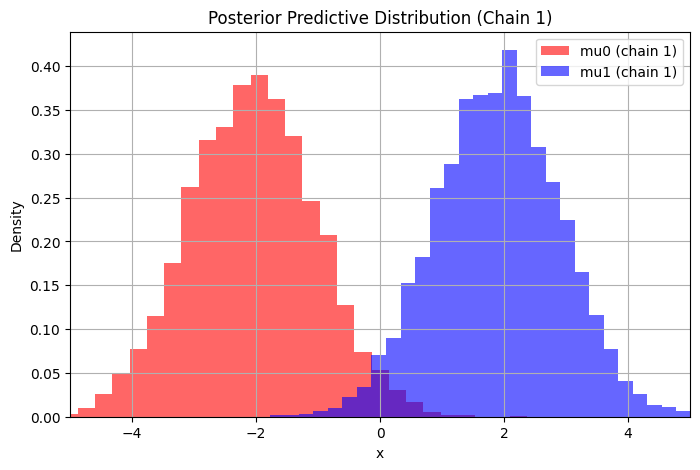

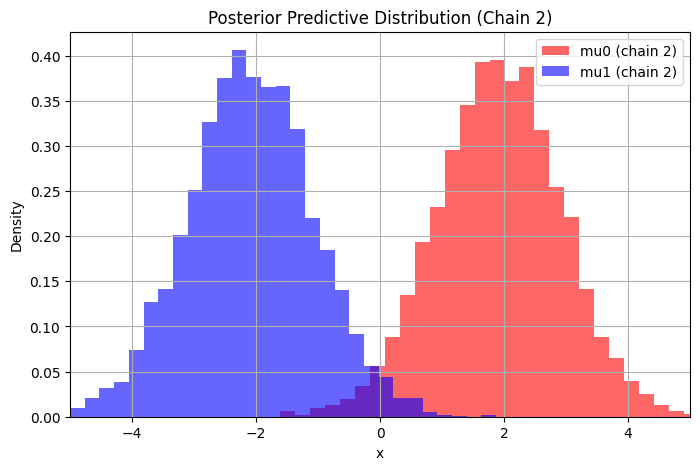

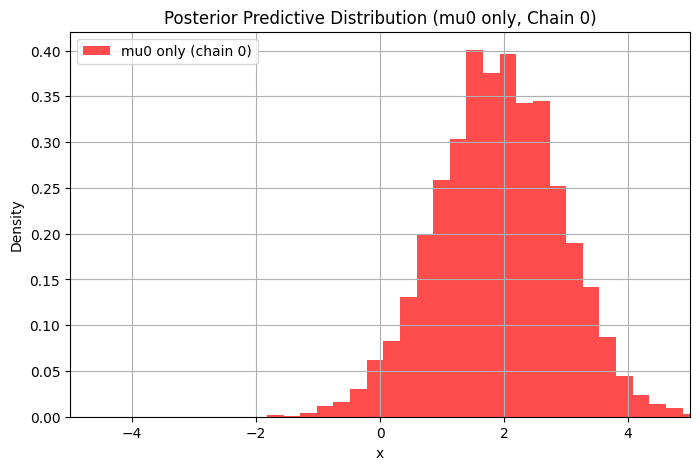

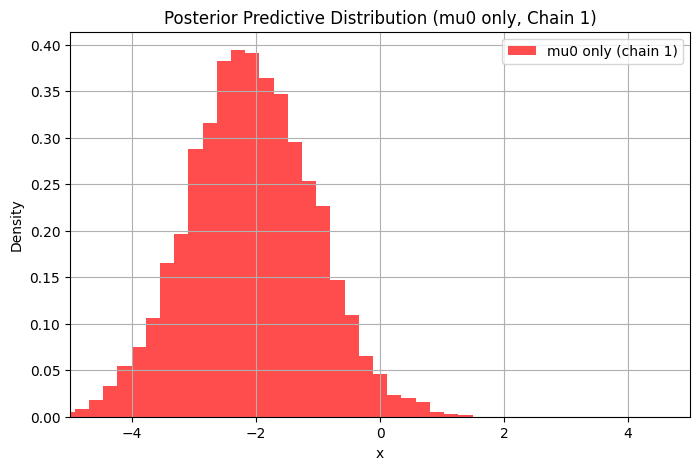

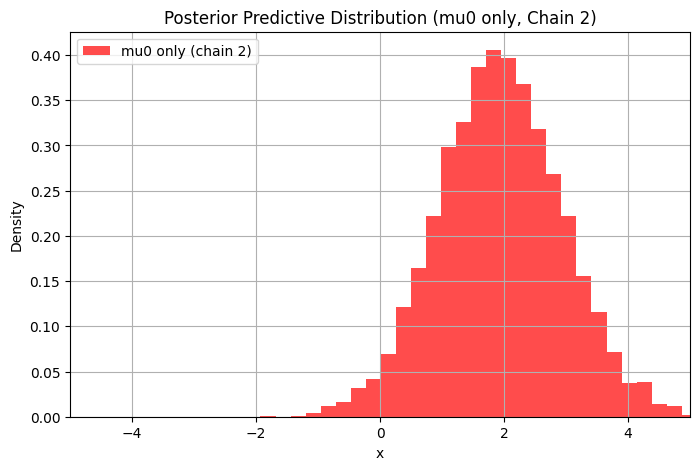

In [3]:
# -----------------------------
# 描画①: 観測データの分布
# -----------------------------
plt.figure(figsize=(8, 5))
plt.hist(x_data, bins=30, density=True, color="black", alpha=0.6)
plt.title("Observed Data Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.grid(True)
plt.show()

# -----------------------------
# 描画②: 事前予測分布（mu0=赤、mu1=青）
# -----------------------------
prior_key = random.PRNGKey(0)
num_prior = 100
samples_per_mixture = 50

prior_x_samples_m0 = []
prior_x_samples_m1 = []

for i in range(num_prior):
    subkey = random.fold_in(prior_key, i)
    mu0 = dist.Normal(-1, 1).sample(subkey)
    mu1 = dist.Normal(1, 1).sample(random.fold_in(subkey, 1))

    x0 = dist.Normal(mu0, 1.0).sample(random.fold_in(subkey, 10), (samples_per_mixture,))
    x1 = dist.Normal(mu1, 1.0).sample(random.fold_in(subkey, 11), (samples_per_mixture,))

    prior_x_samples_m0.append(x0)
    prior_x_samples_m1.append(x1)

prior_x_samples_m0 = jnp.concatenate(prior_x_samples_m0)
prior_x_samples_m1 = jnp.concatenate(prior_x_samples_m1)

plt.figure(figsize=(8, 5))
plt.hist(prior_x_samples_m0, bins=30, density=True, color="red", alpha=0.4, label="mu0 prior")
plt.hist(prior_x_samples_m1, bins=30, density=True, color="blue", alpha=0.4, label="mu1 prior")
plt.title("Prior Predictive Distribution (Separated)")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 描画③: 事前予測分布（mu0のみ）
# -----------------------------
prior_x_samples_mu0_only = []

for i in range(num_prior):
    subkey = random.fold_in(prior_key, 100 + i)  # ②とキーの衝突を避ける
    mu0 = dist.Normal(-1, 1).sample(subkey)
    x0 = dist.Normal(mu0, 1.0).sample(random.fold_in(subkey, 10), (samples_per_mixture,))
    prior_x_samples_mu0_only.append(x0)

prior_x_samples_mu0_only = jnp.concatenate(prior_x_samples_mu0_only)

plt.figure(figsize=(8, 5))
plt.hist(prior_x_samples_mu0_only, bins=30, density=True, color="red", alpha=0.5, label="mu0 only prior")
plt.title("Prior Predictive Distribution (mu0 only)")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 描画④: 事後予測分布（chain 0, 1, 2）
# -----------------------------
num_draws = 100  # 描画に使用するサンプル数

for chain_id in range(num_chains):
    posterior_x_samples_m0 = []
    posterior_x_samples_m1 = []

    mu0_chain = posterior_samples["mu0"][chain_id]
    mu1_chain = posterior_samples["mu1"][chain_id]

    for i in range(num_draws):
        subkey = random.fold_in(prior_key, 2000 + 100 * chain_id + i)
        mu0 = mu0_chain[i]
        mu1 = mu1_chain[i]

        x0 = dist.Normal(mu0, 1.0).sample(random.fold_in(subkey, 20), (samples_per_mixture,))
        x1 = dist.Normal(mu1, 1.0).sample(random.fold_in(subkey, 21), (samples_per_mixture,))

        posterior_x_samples_m0.append(x0)
        posterior_x_samples_m1.append(x1)

    posterior_x_samples_m0 = jnp.concatenate(posterior_x_samples_m0)
    posterior_x_samples_m1 = jnp.concatenate(posterior_x_samples_m1)

    plt.figure(figsize=(8, 5))
    plt.hist(posterior_x_samples_m0, bins=30, density=True, color="red", alpha=0.6, label=f"mu0 (chain {chain_id})")
    plt.hist(posterior_x_samples_m1, bins=30, density=True, color="blue", alpha=0.6, label=f"mu1 (chain {chain_id})")
    plt.title(f"Posterior Predictive Distribution (Chain {chain_id})")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.legend()
    plt.show()

# -----------------------------
# 描画⑤: 事後予測分布（mu0のみ, chain 0, 1, 2）
# -----------------------------
for chain_id in range(num_chains):
    posterior_x_samples_mu0 = []
    mu0_chain = posterior_samples["mu0"][chain_id]

    for i in range(num_draws):
        subkey = random.fold_in(prior_key, 3000 + 100 * chain_id + i)
        mu0 = mu0_chain[i]

        x0 = dist.Normal(mu0, 1.0).sample(random.fold_in(subkey, 30), (samples_per_mixture,))
        posterior_x_samples_mu0.append(x0)

    posterior_x_samples_mu0 = jnp.concatenate(posterior_x_samples_mu0)

    plt.figure(figsize=(8, 5))
    plt.hist(posterior_x_samples_mu0, bins=30, density=True, color="red", alpha=0.7,
             label=f"mu0 only (chain {chain_id})")
    plt.title(f"Posterior Predictive Distribution (mu0 only, Chain {chain_id})")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.legend()
    plt.show()
